# start

- http://localhost:8081/notebooks/git/recsys20/working/0324_6_3_lgb_feat_engr-1e7.ipynb
- http://localhost:8081/notebooks/git/recsys20/working/mdl0404_1__xgb_mean_encode.ipynb
- http://localhost:8081/notebooks/git/recsys20/working/eda_0404_1.ipynb#v.s.-target
- https://www.kaggle.com/discdiver/category-encoders-examples
- https://www.kaggle.com/snakayama/lightgbm-using-optuna-optuna-lightgbm

In [1]:
TGT='Reply'
PRFX='Reply0411_1'

trntmstmp=1584412344
tsttmstmp=1586133347

tm_trn_min,tm_trn_max=(1580947200, 1581551999)
tm_tst_min,tm_tst_max=(1581552000, 1582156799)

SEED=101

valsz = int(5e5)#int(1e5)
trnsz = int(5e5)#int(5e5)

train_total=148075238
test_total=int(1.4e7)
print(f'train_total {train_total:,}, test_total {test_total:,}')


import datetime
def showtm(tm): return datetime.datetime.fromtimestamp(tm).strftime('%Y-%m-%d %H:%M:%S')
print([showtm(tm) for tm in (trntmstmp, tsttmstmp)])
print([showtm(tm) for tm in (tm_trn_min,tm_trn_max)])
print([showtm(tm) for tm in (tm_tst_min,tm_tst_max)])

train_total 148,075,238, test_total 14,000,000
['2020-03-17 02:32:24', '2020-04-06 00:35:47']
['2020-02-06 00:00:00', '2020-02-12 23:59:59']
['2020-02-13 00:00:00', '2020-02-19 23:59:59']


# setup

In [2]:
from tqdm import tqdm
import time
from pathlib import Path
from collections import Counter,defaultdict
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve
import pickle
# import xgboost as xgb
# import lightgbm as lgb
import category_encoders as ce
import gc

import optuna
# optuna.logging.CRITICAL, optuna.logging.FATAL
# optuna.logging.ERROR
# optuna.logging.WARNING, optuna.logging.WARN
# optuna.logging.INFO
# optuna.logging.DEBUG
# optuna.logging.set_verbosity(optuna.logging.ERROR)
import optuna.integration.lightgbm as lgb
optuna.logging.disable_default_handler()


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


import datetime
def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

def iou(s1,s2):
    return len(s1&s2) / len(s1|s2)

HOME='/data/git/recsys20'
p_in=f'{HOME}/input'
p_out=f'{HOME}/output/{PRFX}'
Path(p_out).mkdir(exist_ok=True, parents=True)

from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

# https://towardsdatascience.com/how-to-calibrate-undersampled-model-scores-8f3319c1ea5b
# How to use the function?
# Let’s say your goal is to generate a model that shows the credit default probabilities and your original 
# training data has 50,000 rows with only 500 of them labeled as target class. When you sample your non-target 
# instances randomly and reduce the total row count to 10,000, while conserving 500 target rows, our calibration
# function becomes:
# calibration(model_results, 50000, 500, 10000, 500)
# Here model_results is your model probability output array. After you train your model and put the results in it, your function is ready to use. 
def calibration(data, train_pop, target_pop, sampled_train_pop, sampled_target_pop):
    calibrated_data = ((data * (target_pop / train_pop) / (sampled_target_pop / sampled_train_pop)) /
    (((1 - data) * (1 - target_pop / train_pop) / (1 - sampled_target_pop / sampled_train_pop)) +
     (data * (target_pop / train_pop) / (sampled_target_pop / sampled_train_pop))))
    return calibrated_data


cols=['toks','hshtgs','twtid','media','links','domns','twttyp','lang','tm','u1id','u1_fllwer_cnt','u1_fllwing_cnt','u1_vrfed','u1_create_tm','u2id','u2_fllwer_cnt','u2_fllwng_cnt','u2_vrfed','u2_create_tm','u1_fllw_u2','reply_tm','retwt_tm','retwt_cmmnt_tm','like_tm',]

cols_val = cols[:-4]
cols_tgt_tmstmp=[ 'retwt_tm', 'reply_tm', 'like_tm', 'retwt_cmmnt_tm',]
cols_tgt=[o.split('_tm')[0] for o in cols_tgt_tmstmp]
tgts             = ['Retweet','Reply','Like','RTwCmnt',]
assert cols_tgt == ['retwt',  'reply','like','retwt_cmmnt',]
tgt2col = dict(zip(tgts, cols_tgt))
TCOL=tgt2col[TGT]
print('TCOL', TCOL)
print(tgt2col)

TCOL reply
{'Retweet': 'retwt', 'Reply': 'reply', 'Like': 'like', 'RTwCmnt': 'retwt_cmmnt'}


# prep

In [3]:
def prp_tgt(df):
    df[cols_tgt]=df[cols_tgt_tmstmp].notna()
    df.drop(columns=cols_tgt_tmstmp, inplace=True)
    display(df[cols_tgt].mean())

In [4]:
%%time
dfval = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=valsz)
print(dfval.shape)
prp_tgt(dfval)

(500000, 24)


retwt          0.112638
reply          0.027980
like           0.439010
retwt_cmmnt    0.007676
dtype: float64

CPU times: user 3.66 s, sys: 428 ms, total: 4.09 s
Wall time: 4.1 s


## maybe oversample

In [5]:
# df = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=5)
# dfval = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=2)
# dftrn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,skiprows=2,nrows=3)
# display(df.twtid)
# display(dfval.twtid)
# display(dftrn.twtid)

# 0    D4D1EBDE74F74C5DA529959AF979625C
# 1    BFB529DAB6D384EB83E899A72AB3830D
# 2    519078C7834E9642508F72A6C2D0F3B7
# 3    52AAE9E33EFAC8C478C57B31A9E31ED1
# 4    89C1298C55EB3D68E2784F0BFB69E6F8
# Name: twtid, dtype: object
# 0    D4D1EBDE74F74C5DA529959AF979625C
# 1    BFB529DAB6D384EB83E899A72AB3830D
# Name: twtid, dtype: object
# 0    519078C7834E9642508F72A6C2D0F3B7
# 1    52AAE9E33EFAC8C478C57B31A9E31ED1
# 2    89C1298C55EB3D68E2784F0BFB69E6F8
# Name: twtid, dtype: object

In [6]:
%%time
if TGT in ('Retweet','Like'): trnpop=trnsz
if TGT=='Reply': trnpop=trnsz*3.7
if TGT=='RTwCmnt': trnpop=trnsz*11.5
assert trnpop<train_total

dftrn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,
                     skiprows=valsz, nrows=trnpop)
print(dftrn.shape)
prp_tgt(dftrn)

(1850000, 24)


retwt          0.112795
reply          0.027393
like           0.439040
retwt_cmmnt    0.007702
dtype: float64

CPU times: user 14.3 s, sys: 1.57 s, total: 15.9 s
Wall time: 15.9 s


In [7]:
train_pop=len(dftrn)
sampled_train_pop=trnsz
idx_pos = np.where(dftrn[TCOL])[0]
target_pop=sampled_target_pop=len(idx_pos)
if TGT in ('Reply','RTwCmnt'):
    idx_neg0 = np.where(~dftrn[TCOL])[0]
    idx_neg = np.random.choice(idx_neg0, trnsz-len(idx_pos), replace=False)
    idx = np.concatenate([idx_pos,idx_neg])
    dftrn = dftrn.iloc[idx].copy()
print(dftrn.shape, dftrn[TCOL].mean())
print(train_pop, target_pop, sampled_train_pop, sampled_target_pop)

display(dftrn.head())
display(dftrn.columns)

(500000, 24) 0.101354
1850000 50677 500000 50677


,toks,hshtgs,twtid,media,links,domns,twttyp,lang,tm,u1id,u1_fllwer_cnt,u1_fllwing_cnt,u1_vrfed,u1_create_tm,u2id,u2_fllwer_cnt,u2_fllwng_cnt,u2_vrfed,u2_create_tm,u1_fllw_u2,retwt,reply,like,retwt_cmmnt
9,101\t137\t48201\t10133\t44026\t10884\t11305\t9...,NaN,24669C0DADEA57A75F6BE24CAC0ACCB9,Photo,NaN,NaN,TopLevel,22C448FF81263D4BAF2A176145EE9EAD,1580948734,A6E0653718DB85566D3E6D1E2989AC6D,145,61,False,1522591408,06E9B9E30FB6A7F37CA6B42264C30103,407,385,False,1274938010,True,False,True,False,False
11,101\t2341\t7911\t121\t12236\t7596\t7431\t12290...,NaN,E15A666B6A975581F5CE3F2286CDB408,Photo,NaN,NaN,TopLevel,22C448FF81263D4BAF2A176145EE9EAD,1581344753,74BD974C794C3C2D604E92F9402AB810,318,252,False,1464834037,06E9B9E30FB6A7F37CA6B42264C30103,407,385,False,1274938010,True,False,True,False,False
26,101\t144\t87051\t10354\t16874\t196\t10117\t172...,NaN,D8334D0798821B6A99A9C7A4C9E4E3E1,NaN,8FBB6E6890E2ED0F608F83345CB5EA2F,FFA7BC68DEEFEE9FE34F150D60FEA189,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,1581149159,4CA2E59BBCCB899954E82B01D61C8DF1,16974,612,False,1397475686,06E9CB2FE3EE244FC5D3E2A7E0B7A460,66,512,False,1498734232,False,False,True,False,False
96,101\t11589\t39520\t18487\t58136\t10121\t10911\...,NaN,0C55DCB7494C90953ACE5E70A46B8AA9,NaN,NaN,NaN,TopLevel,06D61DCBBE938971E1EA0C38BD9B5446,1581470640,58867654CB709C6FBA4F332ED479EF1A,418,554,False,1354395470,06E9F8C1FB619A5AE34B3BE57632DB16,178,339,False,1538938782,True,False,True,True,False
303,101\t65000\t112\t188\t19556\t12172\t10133\t218...,NaN,3058691BBE196B9A3702A8E7584944E9,NaN,NaN,NaN,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,1580980182,B31DCBBAE66B1E22B1531F77538E88E7,19,440,False,1476507467,06EADF03A34F162DE8051C27C439F6BB,172,167,False,1418024844,True,False,True,False,False


Index(['toks', 'hshtgs', 'twtid', 'media', 'links', 'domns', 'twttyp', 'lang',
       'tm', 'u1id', 'u1_fllwer_cnt', 'u1_fllwing_cnt', 'u1_vrfed',
       'u1_create_tm', 'u2id', 'u2_fllwer_cnt', 'u2_fllwng_cnt', 'u2_vrfed',
       'u2_create_tm', 'u1_fllw_u2', 'retwt', 'reply', 'like', 'retwt_cmmnt'],
      dtype='object')

## prep and features

In [8]:
def prp_df(df, tm_max):
    '''
    tm_max = tm_trn_max for train tm_tst_max for test
    '''
    lendf = len(df)
    print(dtnow(), 'start')
    set_u1 = set(df.u1id)
    set_u2 = set(df.u2id)
    df['u1inu2']=df.u1id.isin(set_u2)
    df['u2inu1']=df.u2id.isin(set_u1)

    #counts
    df['len_toks'] = df.toks.apply(lambda x: len(x.split('\t')))
    df.drop(columns=['toks'], inplace=True)    
    for m in ['Photo', 'Video', 'GIF']:
        df[f'n_media_{m}'] = df['media'].fillna('').apply(lambda x: x.split('\t').count(m))
    tgnms = ['hshtgs','media', 'links', 'domns',]
    for tgnm in tgnms:
        df[f'has_{tgnm}']=df[tgnm].notna()
        df[f'lst_{tgnm}'] = df[tgnm].fillna('').apply(lambda x: x.split('\t') if len(x) else [])
        df[f'n_{tgnm}'] = df[f'lst_{tgnm}'].apply(len)  
    df.drop(columns=['has_links','n_links'], inplace=True) #duplicates has_domns,n_domns 
    
    #time
    dt = pd.to_datetime(df.tm, unit='s')
    df['dayofweek'] = dt.dt.dayofweek
    df['hour'] = dt.dt.hour
    
    df['tmdlta_u2u1']  = df.u2_create_tm - df.u1_create_tm
    df['tmdlta_twtu1'] = df.tm - df.u1_create_tm
    df['tmdlta_twtu2'] = df.tm - df.u2_create_tm

    df['twt_age']   = tm_max-df.tm
    df['u1_age']    = tm_max-df.u1_create_tm
    df['u2_age']    = tm_max-df.u2_create_tm
    df.drop(columns=['tm', 'u1_create_tm', 'u2_create_tm'], inplace=True)

    #time derived
    df['u1_fllwer_cnt_by_age'] = df.u1_fllwer_cnt / df.u1_age
    df['u1_fllwng_cnt_by_age'] = df.u2_fllwng_cnt / df.u2_age
    
    #interaction
    df['u1u2']=df.u1id+'_'+df.u2id
    df['langhour']=df.lang+'_'+df.hour.astype(str)
    

    #freq of feature values
    print(dtnow(), 'freq of columns using CountEncoder')
    encoder = ce.CountEncoder()
    encoded = encoder.fit_transform(
    df[['twtid', 'twttyp', 'lang', 'u1id', 'u1_fllwing_cnt', 'u1_vrfed', 'u2id', 'u2_fllwer_cnt', 'u2_vrfed', 'u1_fllw_u2', 
       'n_media_Photo', 'n_media_Video', 'n_media_GIF', 
       'has_hshtgs', 'n_hshtgs', 'has_media', 'n_media','has_domns', 'n_domns', 
       'dayofweek', 'hour', 'u1u2', 'langhour']].astype(object))
    encoded = encoded.astype(int)/lendf
    encoded.columns = [f'frq_{col}' for col in encoded.columns]
    df = pd.concat([df,encoded],1)
    
    #freq of tgnm values
    print(dtnow(), 'freq of tags')
    for tgnm in tgnms:
        vs = [j for i in df[f'lst_{tgnm}'] for j in i]
        cnt = Counter(vs)
        frq = {k:v/lendf for k,v in cnt.items()}
        df[f'sumfrq_{tgnm}']=df[f'lst_{tgnm}'].apply(lambda x: sum([frq.get(o,0) for o in x]))
        df[f'maxfrq_{tgnm}']=df[f'lst_{tgnm}'].apply(lambda x: max([frq.get(o,0) for o in x]) if len(x) else 0)
    df.drop(columns=tgnms+[f'lst_{tgnm}' for tgnm in tgnms],inplace=True)

    print(dtnow(), 'done')
    return df

In [9]:
%%time
dftrn=prp_df(dftrn, tm_max=tm_trn_max)

2020-04-11 18:37:47 start
2020-04-11 18:37:56 freq of columns using CountEncoder


/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/category_encoders/count.py:255: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  X.loc[:, self.cols] = X.fillna(value=pd.np.nan)


2020-04-11 18:38:11 freq of tags
2020-04-11 18:38:16 done
CPU times: user 26.2 s, sys: 3.25 s, total: 29.5 s
Wall time: 29.4 s


In [10]:
%%time
dfval=prp_df(dfval, tm_max=tm_trn_max)

2020-04-11 18:38:16 start
2020-04-11 18:38:24 freq of columns using CountEncoder
2020-04-11 18:38:36 freq of tags
2020-04-11 18:38:40 done
CPU times: user 21.1 s, sys: 2.77 s, total: 23.9 s
Wall time: 23.8 s


## tr vl split and target encoding

In [11]:
msk_vl=np.random.rand(len(dftrn))<0.15
idxvl=np.where( msk_vl)[0]
idxtr=np.where(~msk_vl)[0]

dftr = dftrn.iloc[idxtr].copy()
dfvl = dftrn.iloc[idxvl].copy()
del dftrn

gc.collect()

30

In [12]:
dftr.columns

Index(['twtid', 'twttyp', 'lang', 'u1id', 'u1_fllwer_cnt', 'u1_fllwing_cnt',
       'u1_vrfed', 'u2id', 'u2_fllwer_cnt', 'u2_fllwng_cnt', 'u2_vrfed',
       'u1_fllw_u2', 'retwt', 'reply', 'like', 'retwt_cmmnt', 'u1inu2',
       'u2inu1', 'len_toks', 'n_media_Photo', 'n_media_Video', 'n_media_GIF',
       'has_hshtgs', 'n_hshtgs', 'has_media', 'n_media', 'has_domns',
       'n_domns', 'dayofweek', 'hour', 'tmdlta_u2u1', 'tmdlta_twtu1',
       'tmdlta_twtu2', 'twt_age', 'u1_age', 'u2_age', 'u1_fllwer_cnt_by_age',
       'u1_fllwng_cnt_by_age', 'u1u2', 'langhour', 'frq_twtid', 'frq_twttyp',
       'frq_lang', 'frq_u1id', 'frq_u1_fllwing_cnt', 'frq_u1_vrfed',
       'frq_u2id', 'frq_u2_fllwer_cnt', 'frq_u2_vrfed', 'frq_u1_fllw_u2',
       'frq_n_media_Photo', 'frq_n_media_Video', 'frq_n_media_GIF',
       'frq_has_hshtgs', 'frq_n_hshtgs', 'frq_has_media', 'frq_n_media',
       'frq_has_domns', 'frq_n_domns', 'frq_dayofweek', 'frq_hour', 'frq_u1u2',
       'frq_langhour', 'sumfrq_hshtgs', 

In [13]:
%%time
col2tgtenc=['twtid', 'twttyp', 'lang', 'u1id', 'u1_fllwing_cnt', 'u1_vrfed', 'u2id', 'u2_fllwer_cnt', 'u2_vrfed', 'u1_fllw_u2', 
   'n_media_Photo', 'n_media_Video', 'n_media_GIF', 
   'has_hshtgs', 'n_hshtgs', 'has_media', 'n_media','has_domns', 'n_domns', 
   'dayofweek', 'hour', 'u1u2', 'langhour']
tgt_encoder = ce.TargetEncoder()
encoded_tr = tgt_encoder.fit_transform(dftr[col2tgtenc].astype(object), dftr[TCOL])
encoded_vl = tgt_encoder.transform(dfvl[col2tgtenc].astype(object))
encoded_val = tgt_encoder.transform(dfval[col2tgtenc].astype(object))

tgtenc_columns = [f'tgtenc_{col}' for col in encoded_tr.columns]
encoded_tr.columns = tgtenc_columns
encoded_vl.columns = tgtenc_columns
encoded_val.columns = tgtenc_columns

dftr = pd.concat([dftr, encoded_tr], 1)
dfvl = pd.concat([dfvl, encoded_vl], 1)
dfval = pd.concat([dfval, encoded_val], 1)


CPU times: user 26.6 s, sys: 5.25 s, total: 31.9 s
Wall time: 31.9 s


In [14]:
cols_category=['twttyp', 'lang', 'langhour']
for df in dftr,dfvl,dfval:
    df.drop(columns=['twtid','u1id','u2id','u1u2'], inplace=True)
    df[cols_category]=df[cols_category].astype('category')

In [15]:
cols_feat = [col for col in dftr.columns if col not in cols_tgt]

In [16]:
dftr.dtypes

twttyp                   category
lang                     category
u1_fllwer_cnt               int64
u1_fllwing_cnt              int64
u1_vrfed                     bool
u2_fllwer_cnt               int64
u2_fllwng_cnt               int64
u2_vrfed                     bool
u1_fllw_u2                   bool
retwt                        bool
reply                        bool
like                         bool
retwt_cmmnt                  bool
u1inu2                       bool
u2inu1                       bool
len_toks                    int64
n_media_Photo               int64
n_media_Video               int64
n_media_GIF                 int64
has_hshtgs                   bool
n_hshtgs                    int64
has_media                    bool
n_media                     int64
has_domns                    bool
n_domns                     int64
dayofweek                   int64
hour                        int64
tmdlta_u2u1                 int64
tmdlta_twtu1                int64
tmdlta_twtu2  

# model

In [17]:
cols_feat=['langhour',
 'tgtenc_u2_fllwer_cnt',
 'tgtenc_u1_fllwing_cnt',
 'frq_u2_fllwer_cnt',
 'u1_fllwing_cnt',
 'u2_age',
 'u1_age',
 'tmdlta_twtu2',
 'u1_fllwer_cnt',
 'tgtenc_lang',
 'tmdlta_u2u1',
 'u1_fllwer_cnt_by_age',
 'tmdlta_twtu1',
 'u2_fllwer_cnt',
 'tgtenc_twtid',
 'u1_fllwng_cnt_by_age',
 'len_toks',
 'tgtenc_u1id',
 'lang',
 'frq_langhour',
 'u2_fllwng_cnt',
 'twt_age',
 'tgtenc_u2id',
 'frq_u1_fllwing_cnt',
 'twttyp',
 'frq_u1id',
 'frq_twttyp',
 'tgtenc_langhour',
 'n_domns',
 'sumfrq_hshtgs',
 'has_domns',
 'frq_hour',
 'u1_fllw_u2',
 'tgtenc_hour',
 'n_hshtgs',
 'frq_dayofweek',
 'frq_lang',
 'frq_has_domns',
 'sumfrq_domns',
 'n_media',
 'maxfrq_media',
 'tgtenc_u1u2',
 'frq_n_hshtgs',
 'sumfrq_media',
 'dayofweek',
 'hour',
 'n_media_Photo',
 'n_media_Video',
 'has_media',
 'frq_u1_fllw_u2',
 'frq_u2id',
 'tgtenc_dayofweek',
 'has_hshtgs',
 'frq_twtid',
 'maxfrq_hshtgs',
 'tgtenc_n_hshtgs',
 'frq_u1u2',
 'maxfrq_domns',
 'tgtenc_twttyp',
 'tgtenc_n_media_Video',
 'u1_vrfed',
 'frq_u1_vrfed',
 'frq_n_media_Photo',
 'frq_n_media_Video',
 'frq_n_domns',
 'tgtenc_n_media_Photo',
 'tgtenc_n_media',
 'u1inu2',
 'frq_has_hshtgs',
 'frq_n_media',
 'maxfrq_links',
 'tgtenc_n_domns']

In [18]:
results = {}
results['PRFX'] = PRFX
results['TGT'] = TGT
results['cols_feat'] = cols_feat
results['tgt_encoder'] = tgt_encoder
results['col2tgtenc'] = col2tgtenc

In [19]:
params={
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': 0,    
}
results['params'] = params

In [20]:
%%time
dtr = lgb.Dataset(dftr[cols_feat], label=dftr[TCOL])
dvl = lgb.Dataset(dfvl[cols_feat], label=dfvl[TCOL])
best_params, tuning_history = {}, []
evalres = {}
evallist = [(dtr, 'train'), (dvl, 'eval')]
bst = lgb.train(params=params, 
                train_set=dtr, 
                num_boost_round=50000,
                valid_sets=[dtr, dvl],
                valid_names=['tr','vl'],
                best_params=best_params,
                tuning_history=tuning_history,
                verbose_eval=100,
                early_stopping_rounds=100,
                evals_result=evalres,
               )
results['bst'] = bst
results['evalres'] = evalres
results['best_params']=best_params
results['tuning_history']=tuning_history

/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/optuna/_experimental.py:87: ExperimentalWarning: train is experimental (supported from v0.18.0). The interface can change in the future.
  ExperimentalWarning
tune_feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.181909	vl's binary_logloss: 0.343299
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.236386	vl's binary_logloss: 0.292177


tune_feature_fraction, val_score: 0.292177:  14%|#4        | 1/7 [00:08<00:50,  8.48s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.180846	vl's binary_logloss: 0.359092
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.229137	vl's binary_logloss: 0.292409


tune_feature_fraction, val_score: 0.292177:  29%|##8       | 2/7 [00:12<00:36,  7.24s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.18007	vl's binary_logloss: 0.372538
Early stopping, best iteration is:
[11]	tr's binary_logloss: 0.231227	vl's binary_logloss: 0.293492


tune_feature_fraction, val_score: 0.292177:  43%|####2     | 3/7 [00:17<00:25,  6.36s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.179793	vl's binary_logloss: 0.376253
Early stopping, best iteration is:
[11]	tr's binary_logloss: 0.226455	vl's binary_logloss: 0.29537


tune_feature_fraction, val_score: 0.292177:  57%|#####7    | 4/7 [00:21<00:17,  5.83s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.179231	vl's binary_logloss: 0.380015
Early stopping, best iteration is:
[10]	tr's binary_logloss: 0.228522	vl's binary_logloss: 0.296626


tune_feature_fraction, val_score: 0.292177:  71%|#######1  | 5/7 [00:26<00:11,  5.53s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.178853	vl's binary_logloss: 0.381476
Early stopping, best iteration is:
[9]	tr's binary_logloss: 0.228885	vl's binary_logloss: 0.297898


tune_feature_fraction, val_score: 0.292177:  86%|########5 | 6/7 [00:31<00:05,  5.42s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.178194	vl's binary_logloss: 0.380209
Early stopping, best iteration is:
[9]	tr's binary_logloss: 0.227225	vl's binary_logloss: 0.30018


tune_num_leaves, val_score: 0.292177:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.181213	vl's binary_logloss: 0.343177
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.235978	vl's binary_logloss: 0.292034


tune_num_leaves, val_score: 0.292034:   5%|5         | 1/20 [00:04<01:14,  3.92s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.160427	vl's binary_logloss: 0.345609
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.228441	vl's binary_logloss: 0.290296


tune_num_leaves, val_score: 0.290296:  10%|#         | 2/20 [00:10<01:22,  4.57s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.161713	vl's binary_logloss: 0.345628
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.228885	vl's binary_logloss: 0.29039


tune_num_leaves, val_score: 0.290296:  15%|#5        | 3/20 [00:15<01:24,  4.94s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.160648	vl's binary_logloss: 0.34564
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.228493	vl's binary_logloss: 0.290421


tune_num_leaves, val_score: 0.290296:  20%|##        | 4/20 [00:21<01:23,  5.23s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.184113	vl's binary_logloss: 0.342884
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.237744	vl's binary_logloss: 0.292537


tune_num_leaves, val_score: 0.290296:  25%|##5       | 5/20 [00:25<01:11,  4.75s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.187581	vl's binary_logloss: 0.341284
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.24014	vl's binary_logloss: 0.293681


tune_num_leaves, val_score: 0.290296:  30%|###       | 6/20 [00:28<01:00,  4.29s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.151369	vl's binary_logloss: 0.346755
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.226042	vl's binary_logloss: 0.290086


tune_num_leaves, val_score: 0.290086:  35%|###5      | 7/20 [00:35<01:05,  5.07s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.145426	vl's binary_logloss: 0.347194
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.224479	vl's binary_logloss: 0.29013


tune_num_leaves, val_score: 0.290086:  40%|####      | 8/20 [00:42<01:09,  5.75s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.146013	vl's binary_logloss: 0.347396
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.224666	vl's binary_logloss: 0.290208


tune_num_leaves, val_score: 0.290086:  45%|####5     | 9/20 [00:50<01:08,  6.21s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.149934	vl's binary_logloss: 0.347078
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.225633	vl's binary_logloss: 0.290115


tune_num_leaves, val_score: 0.290086:  50%|#####     | 10/20 [00:57<01:04,  6.44s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.152968	vl's binary_logloss: 0.346719
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.226441	vl's binary_logloss: 0.290285


tune_num_leaves, val_score: 0.290086:  55%|#####5    | 11/20 [01:03<00:58,  6.51s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.151964	vl's binary_logloss: 0.346873
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.226115	vl's binary_logloss: 0.290237


tune_num_leaves, val_score: 0.290086:  60%|######    | 12/20 [01:10<00:52,  6.60s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.152158	vl's binary_logloss: 0.346743
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.226257	vl's binary_logloss: 0.290269


tune_num_leaves, val_score: 0.290086:  65%|######5   | 13/20 [01:17<00:46,  6.66s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.170178	vl's binary_logloss: 0.34512
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.231461	vl's binary_logloss: 0.290821


tune_num_leaves, val_score: 0.290086:  70%|#######   | 14/20 [01:22<00:37,  6.17s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.155186	vl's binary_logloss: 0.346119
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.227084	vl's binary_logloss: 0.290234


tune_num_leaves, val_score: 0.290086:  75%|#######5  | 15/20 [01:29<00:31,  6.30s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.147905	vl's binary_logloss: 0.347158
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.225159	vl's binary_logloss: 0.290072


tune_num_leaves, val_score: 0.290072:  80%|########  | 16/20 [01:36<00:26,  6.57s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.147665	vl's binary_logloss: 0.347583
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.225074	vl's binary_logloss: 0.290265


tune_num_leaves, val_score: 0.290072:  85%|########5 | 17/20 [01:43<00:20,  6.77s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.156294	vl's binary_logloss: 0.346717
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.227369	vl's binary_logloss: 0.290374


tune_num_leaves, val_score: 0.290072:  90%|######### | 18/20 [01:49<00:13,  6.64s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.170945	vl's binary_logloss: 0.344869
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.23164	vl's binary_logloss: 0.290862


tune_num_leaves, val_score: 0.290072:  95%|#########5| 19/20 [01:54<00:06,  6.14s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.148665	vl's binary_logloss: 0.347089
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.225411	vl's binary_logloss: 0.290307


tune_num_leaves, val_score: 0.290072: 100%|##########| 20/20 [02:01<00:00,  6.10s/it]
tune_bagging_fraction_and_bagging_freq, val_score: 0.290072:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.153425	vl's binary_logloss: 0.347115
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.227434	vl's binary_logloss: 0.291138


tune_bagging_fraction_and_bagging_freq, val_score: 0.290072:  10%|#         | 1/10 [00:06<00:58,  6.50s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.151423	vl's binary_logloss: 0.346129
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.226316	vl's binary_logloss: 0.290634


tune_bagging_fraction_and_bagging_freq, val_score: 0.290072:  20%|##        | 2/10 [00:14<00:54,  6.78s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.148239	vl's binary_logloss: 0.346643
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.22518	vl's binary_logloss: 0.29


tune_bagging_fraction_and_bagging_freq, val_score: 0.290000:  30%|###       | 3/10 [00:23<00:52,  7.56s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.153756	vl's binary_logloss: 0.347801
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.227623	vl's binary_logloss: 0.291639


tune_bagging_fraction_and_bagging_freq, val_score: 0.290000:  40%|####      | 4/10 [00:29<00:43,  7.25s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.152879	vl's binary_logloss: 0.347389
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.227182	vl's binary_logloss: 0.290952


tune_bagging_fraction_and_bagging_freq, val_score: 0.290000:  50%|#####     | 5/10 [00:36<00:35,  7.06s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.148638	vl's binary_logloss: 0.346889
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.225356	vl's binary_logloss: 0.29034


tune_bagging_fraction_and_bagging_freq, val_score: 0.290000:  60%|######    | 6/10 [00:44<00:29,  7.39s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.148454	vl's binary_logloss: 0.346943
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.225321	vl's binary_logloss: 0.290164


tune_bagging_fraction_and_bagging_freq, val_score: 0.290000:  70%|#######   | 7/10 [00:52<00:22,  7.65s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.154766	vl's binary_logloss: 0.347295
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.228218	vl's binary_logloss: 0.291364


tune_bagging_fraction_and_bagging_freq, val_score: 0.290000:  80%|########  | 8/10 [00:59<00:14,  7.23s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.149511	vl's binary_logloss: 0.346092
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.225661	vl's binary_logloss: 0.290355


tune_bagging_fraction_and_bagging_freq, val_score: 0.290000:  90%|######### | 9/10 [01:07<00:07,  7.65s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.148966	vl's binary_logloss: 0.346434
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.225422	vl's binary_logloss: 0.290044


tune_bagging_fraction_and_bagging_freq, val_score: 0.290000: 100%|##########| 10/10 [01:15<00:00,  7.60s/it]
tune_feature_fraction, val_score: 0.290000:   0%|          | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.147159	vl's binary_logloss: 0.350897
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.224689	vl's binary_logloss: 0.290429


tune_feature_fraction, val_score: 0.290000:  33%|###3      | 1/3 [00:09<00:18,  9.34s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.146731	vl's binary_logloss: 0.355145
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.221067	vl's binary_logloss: 0.290217


tune_feature_fraction, val_score: 0.290000:  67%|######6   | 2/3 [00:18<00:09,  9.37s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.145571	vl's binary_logloss: 0.36027
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.218474	vl's binary_logloss: 0.289789


tune_feature_fraction, val_score: 0.289789: 100%|##########| 3/3 [00:28<00:00,  9.59s/it]
tune_lambda_l1_and_lambda_l2, val_score: 0.289789:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.146126	vl's binary_logloss: 0.360451
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.218567	vl's binary_logloss: 0.2898


tune_lambda_l1_and_lambda_l2, val_score: 0.289789:   5%|5         | 1/20 [00:09<03:05,  9.74s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.145797	vl's binary_logloss: 0.36059
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.218434	vl's binary_logloss: 0.289826


tune_lambda_l1_and_lambda_l2, val_score: 0.289789:  10%|#         | 2/20 [00:19<02:55,  9.78s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.145698	vl's binary_logloss: 0.360789
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.218436	vl's binary_logloss: 0.289827


tune_lambda_l1_and_lambda_l2, val_score: 0.289789:  15%|#5        | 3/20 [00:29<02:46,  9.82s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.151259	vl's binary_logloss: 0.35617
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.220151	vl's binary_logloss: 0.289667


tune_lambda_l1_and_lambda_l2, val_score: 0.289667:  20%|##        | 4/20 [00:40<02:41, 10.08s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.145766	vl's binary_logloss: 0.360482
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.218474	vl's binary_logloss: 0.289789


tune_lambda_l1_and_lambda_l2, val_score: 0.289667:  25%|##5       | 5/20 [00:51<02:34, 10.28s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.145784	vl's binary_logloss: 0.360243
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.218477	vl's binary_logloss: 0.289661


tune_lambda_l1_and_lambda_l2, val_score: 0.289661:  30%|###       | 6/20 [01:00<02:22, 10.17s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.151281	vl's binary_logloss: 0.355865
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.220269	vl's binary_logloss: 0.289475


tune_lambda_l1_and_lambda_l2, val_score: 0.289475:  35%|###5      | 7/20 [01:11<02:14, 10.36s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.145391	vl's binary_logloss: 0.361054
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.218471	vl's binary_logloss: 0.289698


tune_lambda_l1_and_lambda_l2, val_score: 0.289475:  40%|####      | 8/20 [01:21<02:03, 10.27s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.145918	vl's binary_logloss: 0.360325
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.218496	vl's binary_logloss: 0.289709


tune_lambda_l1_and_lambda_l2, val_score: 0.289475:  45%|####5     | 9/20 [01:31<01:52, 10.23s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.145558	vl's binary_logloss: 0.360336
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.218474	vl's binary_logloss: 0.289789


tune_lambda_l1_and_lambda_l2, val_score: 0.289475:  50%|#####     | 10/20 [01:41<01:40, 10.09s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.159191	vl's binary_logloss: 0.34954
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.222783	vl's binary_logloss: 0.289576


tune_lambda_l1_and_lambda_l2, val_score: 0.289475:  55%|#####5    | 11/20 [01:52<01:33, 10.42s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.154701	vl's binary_logloss: 0.351746
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.222033	vl's binary_logloss: 0.289574


tune_lambda_l1_and_lambda_l2, val_score: 0.289475:  60%|######    | 12/20 [02:03<01:24, 10.59s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.154059	vl's binary_logloss: 0.352577
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.221678	vl's binary_logloss: 0.289458


tune_lambda_l1_and_lambda_l2, val_score: 0.289458:  65%|######5   | 13/20 [02:15<01:15, 10.76s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.147182	vl's binary_logloss: 0.359758
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.21885	vl's binary_logloss: 0.289722


tune_lambda_l1_and_lambda_l2, val_score: 0.289458:  70%|#######   | 14/20 [02:25<01:03, 10.60s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.146305	vl's binary_logloss: 0.359857
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.21855	vl's binary_logloss: 0.2896


tune_lambda_l1_and_lambda_l2, val_score: 0.289458:  75%|#######5  | 15/20 [02:35<00:52, 10.43s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.157839	vl's binary_logloss: 0.350061
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.222849	vl's binary_logloss: 0.289612


tune_lambda_l1_and_lambda_l2, val_score: 0.289458:  80%|########  | 16/20 [02:46<00:42, 10.63s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.145633	vl's binary_logloss: 0.360303
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.218532	vl's binary_logloss: 0.28973


tune_lambda_l1_and_lambda_l2, val_score: 0.289458:  85%|########5 | 17/20 [02:56<00:31, 10.39s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.148129	vl's binary_logloss: 0.359405
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.219116	vl's binary_logloss: 0.28967


tune_lambda_l1_and_lambda_l2, val_score: 0.289458:  90%|######### | 18/20 [03:06<00:20, 10.31s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.145756	vl's binary_logloss: 0.360802
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.218535	vl's binary_logloss: 0.289802


tune_lambda_l1_and_lambda_l2, val_score: 0.289458:  95%|#########5| 19/20 [03:16<00:10, 10.20s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.160879	vl's binary_logloss: 0.347259
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.224095	vl's binary_logloss: 0.289778


tune_lambda_l1_and_lambda_l2, val_score: 0.289458: 100%|##########| 20/20 [03:27<00:00, 10.37s/it]
tune_min_child_samples, val_score: 0.289458:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.154143	vl's binary_logloss: 0.352684
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.221687	vl's binary_logloss: 0.289596


tune_min_child_samples, val_score: 0.289458:  20%|##        | 1/5 [00:11<00:44, 11.13s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.154119	vl's binary_logloss: 0.352487
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.221716	vl's binary_logloss: 0.289458


tune_min_child_samples, val_score: 0.289458:  40%|####      | 2/5 [00:22<00:33, 11.17s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.153969	vl's binary_logloss: 0.352296
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.221679	vl's binary_logloss: 0.289518


tune_min_child_samples, val_score: 0.289458:  60%|######    | 3/5 [00:33<00:22, 11.18s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.15419	vl's binary_logloss: 0.352655
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.221758	vl's binary_logloss: 0.289578


tune_min_child_samples, val_score: 0.289458:  80%|########  | 4/5 [00:44<00:11, 11.16s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.154155	vl's binary_logloss: 0.352497
Early stopping, best iteration is:
[14]	tr's binary_logloss: 0.221826	vl's binary_logloss: 0.289492


tune_min_child_samples, val_score: 0.289458: 100%|##########| 5/5 [00:55<00:00, 11.16s/it]


CPU times: user 1h 4min 35s, sys: 1h 11min 47s, total: 2h 16min 22s
Wall time: 8min 47s


In [21]:
best_params

{'lambda_l1': 1.1341400394360996,
 'lambda_l2': 8.51229773678126,
 'num_leaves': 236,
 'feature_fraction': 0.48000000000000004,
 'bagging_fraction': 0.9749942806190794,
 'bagging_freq': 1,
 'min_child_samples': 10}

## tr vl trajec

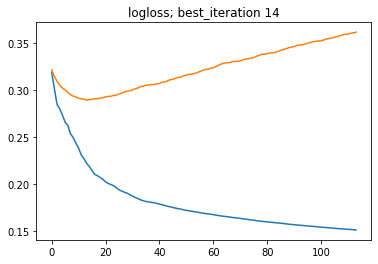

In [22]:
plt.plot(evalres['tr']['binary_logloss'])
plt.plot(evalres['vl']['binary_logloss'])
plt.title(f"logloss; best_iteration {bst.best_iteration}")
plt.show()

## model features

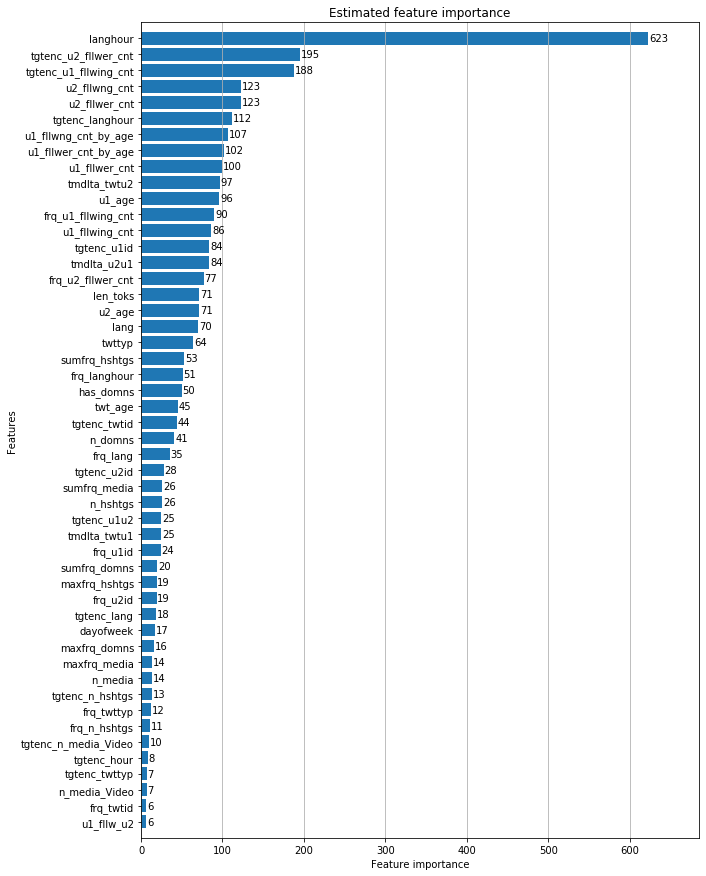

In [23]:
ax = lgb.plot_importance(bst, height=0.8, max_num_features=50, figsize=(10,15))
ax.grid(False, axis="y")
ax.set_title(f'Estimated feature importance')
plt.show()

In [24]:
pd.DataFrame([bst.feature_name(), bst.feature_importance()]).T.sort_values(1, ascending=False)

,0,1
0,langhour,623
1,tgtenc_u2_fllwer_cnt,195
2,tgtenc_u1_fllwing_cnt,188
20,u2_fllwng_cnt,123
13,u2_fllwer_cnt,123
27,tgtenc_langhour,112
15,u1_fllwng_cnt_by_age,107
11,u1_fllwer_cnt_by_age,102
8,u1_fllwer_cnt,100
7,tmdlta_twtu2,97


In [25]:
col2imp = dict(zip(bst.feature_name(), bst.feature_importance()))
sorted(col2imp.items(), key=lambda x: -x[1])

[('langhour', 623),
 ('tgtenc_u2_fllwer_cnt', 195),
 ('tgtenc_u1_fllwing_cnt', 188),
 ('u2_fllwer_cnt', 123),
 ('u2_fllwng_cnt', 123),
 ('tgtenc_langhour', 112),
 ('u1_fllwng_cnt_by_age', 107),
 ('u1_fllwer_cnt_by_age', 102),
 ('u1_fllwer_cnt', 100),
 ('tmdlta_twtu2', 97),
 ('u1_age', 96),
 ('frq_u1_fllwing_cnt', 90),
 ('u1_fllwing_cnt', 86),
 ('tmdlta_u2u1', 84),
 ('tgtenc_u1id', 84),
 ('frq_u2_fllwer_cnt', 77),
 ('u2_age', 71),
 ('len_toks', 71),
 ('lang', 70),
 ('twttyp', 64),
 ('sumfrq_hshtgs', 53),
 ('frq_langhour', 51),
 ('has_domns', 50),
 ('twt_age', 45),
 ('tgtenc_twtid', 44),
 ('n_domns', 41),
 ('frq_lang', 35),
 ('tgtenc_u2id', 28),
 ('n_hshtgs', 26),
 ('sumfrq_media', 26),
 ('tmdlta_twtu1', 25),
 ('tgtenc_u1u2', 25),
 ('frq_u1id', 24),
 ('sumfrq_domns', 20),
 ('frq_u2id', 19),
 ('maxfrq_hshtgs', 19),
 ('tgtenc_lang', 18),
 ('dayofweek', 17),
 ('maxfrq_domns', 16),
 ('n_media', 14),
 ('maxfrq_media', 14),
 ('tgtenc_n_hshtgs', 13),
 ('frq_twttyp', 12),
 ('frq_n_hshtgs', 11),


In [26]:
[o[0] for o in sorted(col2imp.items(), key=lambda x: -x[1]) if o[1]>0]

['langhour',
 'tgtenc_u2_fllwer_cnt',
 'tgtenc_u1_fllwing_cnt',
 'u2_fllwer_cnt',
 'u2_fllwng_cnt',
 'tgtenc_langhour',
 'u1_fllwng_cnt_by_age',
 'u1_fllwer_cnt_by_age',
 'u1_fllwer_cnt',
 'tmdlta_twtu2',
 'u1_age',
 'frq_u1_fllwing_cnt',
 'u1_fllwing_cnt',
 'tmdlta_u2u1',
 'tgtenc_u1id',
 'frq_u2_fllwer_cnt',
 'u2_age',
 'len_toks',
 'lang',
 'twttyp',
 'sumfrq_hshtgs',
 'frq_langhour',
 'has_domns',
 'twt_age',
 'tgtenc_twtid',
 'n_domns',
 'frq_lang',
 'tgtenc_u2id',
 'n_hshtgs',
 'sumfrq_media',
 'tmdlta_twtu1',
 'tgtenc_u1u2',
 'frq_u1id',
 'sumfrq_domns',
 'frq_u2id',
 'maxfrq_hshtgs',
 'tgtenc_lang',
 'dayofweek',
 'maxfrq_domns',
 'n_media',
 'maxfrq_media',
 'tgtenc_n_hshtgs',
 'frq_twttyp',
 'frq_n_hshtgs',
 'tgtenc_n_media_Video',
 'tgtenc_hour',
 'n_media_Video',
 'tgtenc_twttyp',
 'u1_fllw_u2',
 'frq_twtid',
 'frq_hour',
 'frq_u1_fllw_u2',
 'frq_dayofweek',
 'tgtenc_dayofweek',
 'has_hshtgs',
 'tgtenc_n_media_Photo',
 'tgtenc_n_domns',
 'maxfrq_links',
 'frq_u1u2',
 'n_med

# eval

In [27]:
%%time
prdtr = bst.predict(dftr[cols_feat],num_iteration=bst.best_iteration)
prdvl = bst.predict(dfvl[cols_feat],num_iteration=bst.best_iteration)
prdval0 = bst.predict(dfval[cols_feat],num_iteration=bst.best_iteration)
prdval = calibration(prdval0, train_pop, target_pop, sampled_train_pop, sampled_target_pop)

CPU times: user 11 s, sys: 9.29 s, total: 20.3 s
Wall time: 8.31 s


In [28]:
%%time
ytr,yvl,yval=[df[TCOL].values for df in (dftr,dfvl,dfval)]

auc_tr=compute_prauc(prdtr, ytr)
rce_tr=compute_rce(prdtr, ytr)
auc_vl=compute_prauc(prdvl, yvl)
rce_vl=compute_rce(prdvl, yvl)
auc_val=compute_prauc(prdval, yval)
rce_val=compute_rce(prdval, yval)

results['scrs'] = {}
results['scrs']['auc_tr']=auc_tr
results['scrs']['rce_tr']=rce_tr
results['scrs']['auc_vl']=auc_vl
results['scrs']['rce_vl']=rce_vl
results['scrs']['auc_val']=auc_val
results['scrs']['rce_val']=rce_val

CPU times: user 2.97 s, sys: 638 ms, total: 3.61 s
Wall time: 2.86 s


In [29]:
print(f'auc_tr:  {auc_tr:.4f}')
print(f'auc_vl:  {auc_vl:.4f}')
print(f'auc_val: {auc_val:.4f}')
print()
print(f'rce_tr:  {rce_tr:.4f}')
print(f'rce_vl:  {rce_vl:.4f}')
print(f'rce_val: {rce_val:.4f}')

auc_tr:  0.6276
auc_vl:  0.2733
auc_val: 0.0878

rce_tr:  32.3665
rce_vl:  12.1099
rce_val: 9.1710


In [30]:
print(f'-{auc_val:.4f}-{rce_val:.4f}')

-0.0878-9.1710


# save results

In [31]:
pickle.dump(results, open(f'{p_out}/results_{PRFX}.p', 'wb'))

# infer

In [32]:
results = pickle.load( open(f'{p_out}/results_{PRFX}.p', 'rb'))
bst = results['bst']
col2tgtenc = results['col2tgtenc']
cols_feat = results['cols_feat']
tgt_encoder = results['tgt_encoder']

## prep

In [33]:
%%time
dftst=pd.read_csv(
    f'{p_in}/val_{tsttmstmp}.tsv',
    sep='\x01', header=None, names=cols_val, 
    nrows=10
)

CPU times: user 7.8 ms, sys: 0 ns, total: 7.8 ms
Wall time: 6.11 ms


In [34]:
%%time
dftst=prp_df(dftst, tm_max=tm_tst_max)

2020-04-11 18:48:17 start
2020-04-11 18:48:17 freq of columns using CountEncoder


/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/category_encoders/count.py:255: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  X.loc[:, self.cols] = X.fillna(value=pd.np.nan)


2020-04-11 18:48:17 freq of tags
2020-04-11 18:48:17 done
CPU times: user 131 ms, sys: 12 ms, total: 143 ms
Wall time: 134 ms


In [35]:
encoded_tst = tgt_encoder.transform(dftst[col2tgtenc].astype(object))
tgtenc_columns = [f'tgtenc_{col}' for col in encoded_tst.columns]
encoded_tst.columns = tgtenc_columns
dftst = pd.concat([dftst, encoded_tst], 1)
dftst.drop(columns=['u1id','u1u2'], inplace=True)
cols_category=['twttyp', 'lang', 'langhour']
dftst[cols_category]=dftst[cols_category].astype('category')

## predict

In [36]:
%%time
prdtst0 = bst.predict(dftst[cols_feat],num_iteration=bst.best_iteration)
prdtst = calibration(prdtst0, train_pop, target_pop, sampled_train_pop, sampled_target_pop)

CPU times: user 19.5 ms, sys: 9.07 ms, total: 28.6 ms
Wall time: 21.9 ms


In [37]:
dfsub_ids = dftst[['twtid','u2id',]]
dfsub = dfsub_ids.copy()
dfsub['scr'] = prdtst
dfsub.to_csv(f'{p_out}/{TGT}__{PRFX}.csv',index=False,header=False)